In [82]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
from pandas.plotting import scatter_matrix
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

from statsmodels.tsa.seasonal import seasonal_decompose

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amp-parkinsons-disease-progression-prediction/train_proteins.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/train_clinical_data.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/public_timeseries_testing_util.py
/kaggle/input/amp-parkinsons-disease-progression-prediction/supplemental_clinical_data.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/train_peptides.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/amp_pd_peptide/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/amp-parkinsons-disease-progression-prediction/amp_pd_peptide/__init__.py
/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test_files/sample_submission.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test_files/test_proteins.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test_files/test_peptides.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test

In [67]:
train_proteins_df = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/train_proteins.csv')
print('proteins :', train_proteins_df.shape)
print('proteins unique visit_ids:', train_proteins_df.visit_id.nunique())
print(train_proteins_df.columns)

train_peptides_df = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/train_peptides.csv')
print('')
print('peptides :', train_peptides_df.shape)
print('peptides unique visit_ids:', train_peptides_df.visit_id.nunique())
print(train_peptides_df.columns)

train_clinical_data_df = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/train_clinical_data.csv')
print('')
print('clinical :', train_clinical_data_df.shape)
print('clinical unique visit_ids:', train_clinical_data_df.visit_id.nunique())
print(train_clinical_data_df.columns)

supp_clinical_data_df = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/supplemental_clinical_data.csv')
print('')
print('supplemental :', supp_clinical_data_df.shape)
print('supplemental unique visit_ids:', supp_clinical_data_df.visit_id.nunique())
print(supp_clinical_data_df.columns)

proteins : (232741, 5)
proteins unique visit_ids: 1113
Index(['visit_id', 'visit_month', 'patient_id', 'UniProt', 'NPX'], dtype='object')

peptides : (981834, 6)
peptides unique visit_ids: 1113
Index(['visit_id', 'visit_month', 'patient_id', 'UniProt', 'Peptide',
       'PeptideAbundance'],
      dtype='object')

clinical : (2615, 8)
clinical unique visit_ids: 2615
Index(['visit_id', 'patient_id', 'visit_month', 'updrs_1', 'updrs_2',
       'updrs_3', 'updrs_4', 'upd23b_clinical_state_on_medication'],
      dtype='object')

supplemental : (2223, 8)
supplemental unique visit_ids: 2223
Index(['visit_id', 'patient_id', 'visit_month', 'updrs_1', 'updrs_2',
       'updrs_3', 'updrs_4', 'upd23b_clinical_state_on_medication'],
      dtype='object')


* #### Get the relevant training datasets and combine them to form the full training set with Proteins and Peptides
* #### Remove the NaNs from the UPDRS test scores, using the median from within the same group of UPDRS test scores, e.g. NaNs in updrs_4 are filled with mean of updrs_4
* #### Create new mean and median based features and get rid of Proteins Expressions (NPX) and Peptide Abundance

In [68]:
clinical_data = pd.merge(supp_clinical_data_df, train_clinical_data_df, on=['patient_id','visit_id','visit_month'], how='outer')

for i in [1,2,3,4]:
    clinical_data['updrs_'+str(i)] = np.where(clinical_data['updrs_'+str(i)+'_x'].isna(), clinical_data['updrs_'+str(i)+'_y'], clinical_data['updrs_'+str(i)+'_x'])
    clinical_data.drop(columns=['updrs_'+str(i)+'_x', 'updrs_'+str(i)+'_y'], inplace=True)
    
clinical_data.drop(columns=['upd23b_clinical_state_on_medication_x', 'upd23b_clinical_state_on_medication_y'], inplace=True)

print(clinical_data.shape)
print(clinical_data.visit_id.nunique())

del supp_clinical_data_df, train_clinical_data_df

clinical_data.head(10)

(4838, 7)
4838


,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4
0,35_0,35,0,5.0,3.0,16.0,0.0
1,35_36,35,36,6.0,4.0,20.0,0.0
2,75_0,75,0,4.0,6.0,26.0,0.0
3,75_36,75,36,1.0,8.0,38.0,0.0
4,155_0,155,0,NaN,NaN,0.0,NaN
5,337_0,337,0,5.0,7.0,6.0,0.0
6,337_36,337,36,8.0,7.0,8.0,0.0
7,527_0,527,0,6.0,2.0,9.0,0.0
8,527_36,527,36,2.0,18.0,22.0,0.0
9,557_0,557,0,5.0,6.0,22.0,0.0


In [69]:
pro_pep_join = pd.merge(train_proteins_df, train_peptides_df, on=['patient_id','visit_id','visit_month','UniProt'], how='outer')

print(pro_pep_join.shape)
print(pro_pep_join.visit_id.nunique())

del train_proteins_df, train_peptides_df
pro_pep_join.head(10)

(981834, 7)
1113


,visit_id,visit_month,patient_id,UniProt,NPX,Peptide,PeptideAbundance
0,55_0,0,55,O00391,11254.3,NEQEQPLGQWHLS,11254.3
1,55_0,0,55,O00533,732430.0,GNPEPTFSWTK,102060.0
2,55_0,0,55,O00533,732430.0,IEIPSSVQQVPTIIK,174185.0
3,55_0,0,55,O00533,732430.0,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.9
4,55_0,0,55,O00533,732430.0,SMEQNGPGLEYR,30838.7
5,55_0,0,55,O00533,732430.0,TLKIENVSYQDKGNYR,23216.5
6,55_0,0,55,O00533,732430.0,VIAVNEVGR,170878.0
7,55_0,0,55,O00533,732430.0,VMTPAVYAPYDVK,148771.0
8,55_0,0,55,O00533,732430.0,VNGSPVDNHPFAGDVVFPR,55202.1
9,55_0,0,55,O00584,39585.8,ELDLNSVLLK,27229.3


In [70]:
full_training_data = pd.merge(pro_pep_join, clinical_data, on=['patient_id','visit_id','visit_month'], how='outer')
full_training_data = full_training_data.drop(columns=['UniProt','Peptide'])

print(full_training_data.shape)
print(full_training_data.visit_id.nunique())

del pro_pep_join, clinical_data
gc.collect()

full_training_data.head(10)

(985604, 9)
4883


,visit_id,visit_month,patient_id,NPX,PeptideAbundance,updrs_1,updrs_2,updrs_3,updrs_4
0,55_0,0,55,11254.3,11254.3,10.0,6.0,15.0,NaN
1,55_0,0,55,732430.0,102060.0,10.0,6.0,15.0,NaN
2,55_0,0,55,732430.0,174185.0,10.0,6.0,15.0,NaN
3,55_0,0,55,732430.0,27278.9,10.0,6.0,15.0,NaN
4,55_0,0,55,732430.0,30838.7,10.0,6.0,15.0,NaN
5,55_0,0,55,732430.0,23216.5,10.0,6.0,15.0,NaN
6,55_0,0,55,732430.0,170878.0,10.0,6.0,15.0,NaN
7,55_0,0,55,732430.0,148771.0,10.0,6.0,15.0,NaN
8,55_0,0,55,732430.0,55202.1,10.0,6.0,15.0,NaN
9,55_0,0,55,39585.8,27229.3,10.0,6.0,15.0,NaN


In [65]:
temp = full_training_data.groupby(['patient_id','visit_month']).agg(NPX_count=('NPX', 'nunique'), PEP_count=('Peptide', 'nunique'))\
.reset_index(level=['patient_id','visit_month']).sort_values(by=['patient_id','visit_month'],  ascending=True)

temp_1 = temp[temp['NPX_count']>0]
temp_2 = temp[temp['NPX_count']==0]

print('shape of temp, temp_1, temp_2', temp.shape, temp_1.shape, temp_2.shape)
print('number of unique patient_id of temp, temp_1, temp_2', temp.patient_id.nunique(), temp_1.patient_id.nunique(), temp_2.patient_id.nunique())

shape of temp, temp_1, temp_2 (4883, 4) (1113, 4) (3770, 4)
number of unique patient_id of temp, temp_1, temp_2 1019 248 1016


In [51]:
temp_2

,patient_id,visit_month,NPX_count,PEP_count
0,35,0,0,0
1,35,36,0,0
3,55,3,0,0
5,55,9,0,0
7,55,18,0,0
...,...,...,...,...
4878,65382,0,0,0
4879,65405,0,0,0
4880,65405,5,0,0
4881,65530,0,0,0


In [55]:
full_training_data[full_training_data['patient_id']==55].sort_values(by=['visit_month'],  ascending=True)

,visit_id,visit_month,patient_id,UniProt,NPX,Peptide,PeptideAbundance,updrs_1,updrs_2,updrs_3,updrs_4
0,55_0,0,55,O00391,11254.3,NEQEQPLGQWHLS,11254.30,10.0,6.0,15.0,NaN
614,55_0,0,55,P08493,125774.0,YAMVYGYNAAYNR,7181.21,10.0,6.0,15.0,NaN
615,55_0,0,55,P08571,530914.0,AFPALTSLDLSDNPGLGER,102393.00,10.0,6.0,15.0,NaN
616,55_0,0,55,P08571,530914.0,ATVNPSAPR,72001.10,10.0,6.0,15.0,NaN
617,55_0,0,55,P08571,530914.0,TTPEPC(UniMod_4)ELDDEDFR,96095.80,10.0,6.0,15.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
602724,55_36,36,55,P02751,2663520.0,IGDQWDKQHDMGHMMR,41215.90,17.0,18.0,51.0,0.0
984062,55_42,42,55,NaN,NaN,NaN,NaN,12.0,20.0,41.0,0.0
984063,55_48,48,55,NaN,NaN,NaN,NaN,17.0,16.0,52.0,0.0
984064,55_54,54,55,NaN,NaN,NaN,NaN,12.0,18.0,51.0,0.0


<AxesSubplot:xlabel='visit_month'>

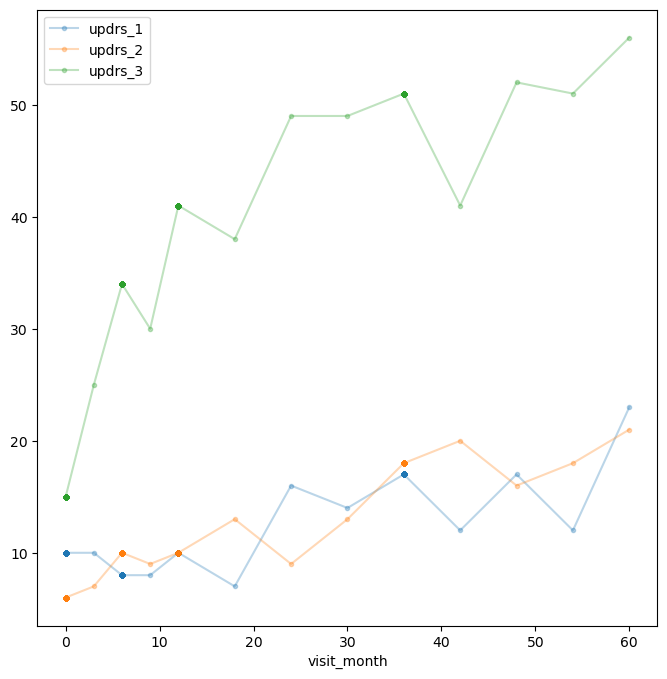

In [64]:
full_training_data[full_training_data['patient_id']==55].sort_values(by=['visit_month'],  ascending=True)\
.plot(kind="line", x="visit_month", y=["updrs_1","updrs_2","updrs_3"], alpha=0.3, figsize=(8,8), marker=".")

In [71]:
columns_to_remove_nan_from = ['updrs_1','updrs_2','updrs_3','updrs_4', 'NPX', 'PeptideAbundance']

for i in columns_to_remove_nan_from:
    full_training_data[i].fillna(full_training_data[i].median().round(decimals = 0), inplace=True)

new_features = full_training_data.groupby(['patient_id','visit_id','visit_month']).agg(npx_mean=('NPX', 'mean'), npx_median=('NPX', 'median')
                                                                          , peptide_mean=('PeptideAbundance', 'mean'), peptide_median=('PeptideAbundance', 'median')
                                                          ).reset_index(level=['patient_id','visit_id','visit_month'])

full_training_data = pd.merge(full_training_data, new_features, on=['patient_id','visit_id','visit_month'], how='inner')

#full_training_data['NPX_standardised'] = (full_training_data['NPX'] - full_training_data['NPX'].mean())/full_training_data['NPX'].std()
#full_training_data['Pep_standardised'] = (full_training_data['PeptideAbundance'] - full_training_data['PeptideAbundance'].mean())/full_training_data['PeptideAbundance'].std()

#full_training_data = full_training_data.drop(columns=['NPX','PeptideAbundance'])
full_training_data = full_training_data.drop_duplicates(keep='first')
full_training_data = full_training_data[['patient_id','visit_id','visit_month', 'npx_mean','npx_median','peptide_mean'
                                         ,'peptide_median','updrs_1','updrs_2','updrs_3','updrs_4']]
#full_training_data = full_training_data[['visit_id','visit_month','NPX_standardised','Pep_standardised','updrs_1','updrs_2','updrs_3','updrs_4']]
full_training_data = full_training_data.drop_duplicates()


full_training_data_sorted = full_training_data.sort_values(by=['patient_id','visit_month'],  ascending=True)

full_training_data_sorted['npx_mean_lag'] = full_training_data_sorted.groupby(['patient_id'])['npx_mean'].shift(1)
full_training_data_sorted['npx_mean_lag'].fillna(0, inplace=True)

full_training_data_sorted['npx_median_lag'] = full_training_data_sorted.groupby(['patient_id'])['npx_median'].shift(1)
full_training_data_sorted['npx_median_lag'].fillna(0, inplace=True)

full_training_data_sorted['peptide_mean_lag'] = full_training_data_sorted.groupby(['patient_id'])['peptide_mean'].shift(1)
full_training_data_sorted['peptide_mean_lag'].fillna(0, inplace=True)

full_training_data_sorted['peptide_median_lag'] = full_training_data_sorted.groupby(['patient_id'])['peptide_median'].shift(1)
full_training_data_sorted['peptide_median_lag'].fillna(0, inplace=True)

full_training_data_sorted = full_training_data_sorted.reset_index()
full_training_data_sorted = full_training_data_sorted.drop(columns=['patient_id','index'])

del full_training_data
gc.collect()
full_training_data_sorted.head(10)

,visit_id,visit_month,npx_mean,npx_median,peptide_mean,peptide_median,updrs_1,updrs_2,updrs_3,updrs_4,npx_mean_lag,npx_median_lag,peptide_mean_lag,peptide_median_lag
0,35_0,0,9.922740e+05,992274.0,74308.000000,74308.0,5.0,3.0,16.0,0.0,0.000000e+00,0.0,0.000000,0.0
1,35_36,36,9.922740e+05,992274.0,74308.000000,74308.0,6.0,4.0,20.0,0.0,9.922740e+05,992274.0,74308.000000,74308.0
2,55_0,0,2.028789e+07,1221530.0,748153.907014,93134.8,10.0,6.0,15.0,0.0,0.000000e+00,0.0,0.000000,0.0
3,55_3,3,9.922740e+05,992274.0,74308.000000,74308.0,10.0,7.0,25.0,0.0,2.028789e+07,1221530.0,748153.907014,93134.8
4,55_6,6,1.843914e+07,1259380.0,685218.599872,84814.9,8.0,10.0,34.0,0.0,9.922740e+05,992274.0,74308.000000,74308.0
5,55_9,9,9.922740e+05,992274.0,74308.000000,74308.0,8.0,9.0,30.0,0.0,1.843914e+07,1259380.0,685218.599872,84814.9
6,55_12,12,2.010976e+07,1241850.0,740535.423563,91575.2,10.0,10.0,41.0,0.0,9.922740e+05,992274.0,74308.000000,74308.0
7,55_18,18,9.922740e+05,992274.0,74308.000000,74308.0,7.0,13.0,38.0,0.0,2.010976e+07,1241850.0,740535.423563,91575.2
8,55_24,24,9.922740e+05,992274.0,74308.000000,74308.0,16.0,9.0,49.0,0.0,9.922740e+05,992274.0,74308.000000,74308.0
9,55_30,30,9.922740e+05,992274.0,74308.000000,74308.0,14.0,13.0,49.0,0.0,9.922740e+05,992274.0,74308.000000,74308.0


In [38]:
full_training_data_sorted[['updrs_1','npx_mean','npx_median','peptide_mean','peptide_median'
                           ,'npx_mean_lag','npx_median_lag','peptide_mean_lag','peptide_median_lag','visit_month']].corr()

,updrs_1,npx_mean,npx_median,peptide_mean,peptide_median,npx_mean_lag,npx_median_lag,peptide_mean_lag,peptide_median_lag,visit_month
updrs_1,1.000000,0.005254,-0.041663,0.007231,-0.026430,0.021292,0.068907,0.028685,0.072150,0.156118
npx_mean,0.005254,1.000000,0.193558,0.996372,0.163458,-0.019249,0.037761,-0.016558,0.040548,0.074560
npx_median,-0.041663,0.193558,1.000000,0.197229,0.752663,-0.013846,0.010394,-0.011834,0.007289,0.011702
peptide_mean,0.007231,0.996372,0.197229,1.000000,0.191735,-0.021563,0.038284,-0.018348,0.041548,0.075788
peptide_median,-0.026430,0.163458,0.752663,0.191735,1.000000,-0.005644,0.006592,-0.000768,0.013481,0.004793
npx_mean_lag,0.021292,-0.019249,-0.013846,-0.021563,-0.005644,1.000000,0.342031,0.994780,0.334514,0.215146
npx_median_lag,0.068907,0.037761,0.010394,0.038284,0.006592,0.342031,1.000000,0.399427,0.993514,0.512721
peptide_mean_lag,0.028685,-0.016558,-0.011834,-0.018348,-0.000768,0.994780,0.399427,1.000000,0.395741,0.244639
peptide_median_lag,0.072150,0.040548,0.007289,0.041548,0.013481,0.334514,0.993514,0.395741,1.000000,0.512563
visit_month,0.156118,0.074560,0.011702,0.075788,0.004793,0.215146,0.512721,0.244639,0.512563,1.000000


#### Check for NaNs

In [72]:
full_training_data_sorted.isna().sum()

visit_id              0
visit_month           0
npx_mean              0
npx_median            0
peptide_mean          0
peptide_median        0
updrs_1               0
updrs_2               0
updrs_3               0
updrs_4               0
npx_mean_lag          0
npx_median_lag        0
peptide_mean_lag      0
peptide_median_lag    0
dtype: int64

#### We will attempt to train one model each for each of the UPDRS tests. To do that, we will also proceed to create a train-test split on the Training dataset specific to each of the UPDRS test, to test out the accuracy of the developed models
#### We will store all the models in a dictionary
#### The following cells (except the declaration of the model dict) will be repeated for all UPDRS tests

In [ ]:
"""model_dict = {}

for i in [1,2,3,4]:
    if (i == 1) | (i == 2):
        full_training_data['updrs_'+str(i)+'_category'] = pd.cut(full_training_data['updrs_'+str(i)],bins=[-np.inf, 15., np.inf],labels=[1,2])
    elif i == 3:
        full_training_data['updrs_'+str(i)+'_category'] = pd.cut(full_training_data['updrs_'+str(i)],bins=[-np.inf, 20., 40., np.inf],labels=[1,2,3])
    else:
        full_training_data['updrs_'+str(i)+'_category'] = pd.cut(full_training_data['updrs_'+str(i)],bins=[-np.inf, 7.5, np.inf],labels=[1,2])
        
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_index, test_index in split.split(full_training_data, full_training_data['updrs_'+str(i)+'_category']):
        strat_train_set = full_training_data.loc[train_index]
        strat_test_set = full_training_data.loc[test_index]
        
    if i == 1:
        strat_train_set = strat_train_set.drop(columns=['updrs_1_category'])
        strat_test_set = strat_test_set.drop(columns=['updrs_1_category'])
    elif i == 2:
        strat_train_set = strat_train_set.drop(columns=['updrs_1_category','updrs_2_category'])
        strat_test_set = strat_test_set.drop(columns=['updrs_1_category','updrs_2_category'])
    elif i == 3:
        strat_train_set = strat_train_set.drop(columns=['updrs_1_category','updrs_2_category','updrs_3_category'])
        strat_test_set = strat_test_set.drop(columns=['updrs_1_category','updrs_2_category','updrs_3_category'])
    else:
        strat_train_set = strat_train_set.drop(columns=['updrs_1_category','updrs_2_category','updrs_3_category','updrs_4_category'])
        strat_test_set = strat_test_set.drop(columns=['updrs_1_category','updrs_2_category','updrs_3_category','updrs_4_category'])
    
    strat_train_set_wo_labels = strat_train_set.drop(columns=['updrs_1','updrs_2','updrs_3','updrs_4','index'])
    strat_train_set_labels = strat_train_set['updrs_'+str(i)].copy()
    strat_train_set_numeric = strat_train_set_wo_labels.drop(columns=['visit_id','visit_month'])
    strat_train_set_cat = strat_train_set_wo_labels[['visit_month']]

    strat_test_set_wo_labels = strat_test_set.drop(columns=['updrs_1','updrs_2','updrs_3','updrs_4','index'])
    strat_test_set_labels = strat_test_set['updrs_'+str(i)].copy()
    
    numeric_pipeline = Pipeline([
        ('standard_scaler', StandardScaler())
    ])

    numeric_attributes = list(strat_train_set_numeric)
    categorical_attributes = list(strat_train_set_cat)

    full_pipeline = ColumnTransformer([
        ('num', numeric_pipeline, numeric_attributes),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_attributes)
    ])

    strat_train_set_prepared = full_pipeline.fit_transform(strat_train_set_wo_labels)
    print(strat_train_set_prepared.shape)
    strat_test_set_prepared = full_pipeline.transform(strat_test_set_wo_labels)
    print(strat_test_set_prepared.shape)
    
    lin_reg = LinearRegression()

    model_dict['updrs_'+str(i)] = lin_reg.fit(strat_train_set_prepared, strat_train_set_labels)
    print(model_dict)"""

In [12]:
"""model_dict = {}

for u in list_of_updrs_tests:
        
    # Drop NAs
    temp = full_training_data_sorted.dropna(subset=[u]) 
    print(u)
    # Train data
    X = temp[['visit_month','npx_mean','npx_median','peptide_mean','peptide_median','npx_mean_lag','npx_median_lag','peptide_mean_lag','peptide_median_lag']]
    #X = temp[['visit_month','NPX_standardised','Pep_standardised']]
    print(X.shape)
    y = temp[u]
    print(y.shape)
    trained = LinearRegression().fit(X, y)
    
    # Save model
    model_dict[u] = trained"""

updrs_1
(4883, 9)
(4883,)
updrs_2
(4883, 9)
(4883,)
updrs_3
(4883, 9)
(4883,)
updrs_4
(4883, 9)
(4883,)


In [8]:
"""poly_model_dict = {}
list_of_updrs_tests = ['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']

for u in list_of_updrs_tests:
        
    # Drop NAs
    temp = full_training_data_sorted.dropna(subset=[u]) 
    print(u)
    # Train data
    X = temp[['visit_month','npx_mean','npx_median','peptide_mean','peptide_median','npx_mean_lag','npx_median_lag','peptide_mean_lag','peptide_median_lag']]
    #X = temp[['visit_month','NPX_standardised','Pep_standardised']]
    print(X.shape)
    y = temp[u]
    print(y.shape)
    poly = PolynomialFeatures(degree = 5)
    X_poly = poly.fit_transform(X)
    poly.fit(X_poly, y)
    print(X_poly.shape)
    trained = LinearRegression().fit(X_poly, y)
    
    # Save model
    poly_model_dict[u] = trained"""

updrs_1
(4883, 9)
(4883,)
(4883, 2002)
updrs_2
(4883, 9)
(4883,)
(4883, 2002)
updrs_3
(4883, 9)
(4883,)
(4883, 2002)
updrs_4
(4883, 9)
(4883,)
(4883, 2002)


In [73]:
decision_model_dict = {}
list_of_updrs_tests = ['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']

for u in list_of_updrs_tests:
        
    # Drop NAs
    temp = full_training_data_sorted.dropna(subset=[u]) 
    print(u)
    # Train data
    X = temp[['visit_month','npx_mean','npx_median','peptide_mean','peptide_median','npx_mean_lag','npx_median_lag','peptide_mean_lag','peptide_median_lag']]
    print(X.shape)
    y = temp[u]
    print(y.shape)
    trained = DecisionTreeRegressor().fit(X, y)
    
    # Save model
    decision_model_dict[u] = trained

updrs_1
(4883, 9)
(4883,)
updrs_2
(4883, 9)
(4883,)
updrs_3
(4883, 9)
(4883,)
updrs_4
(4883, 9)
(4883,)


In [83]:
random_forest_model_dict = {}
list_of_updrs_tests = ['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']

for u in list_of_updrs_tests:
        
    # Drop NAs
    temp = full_training_data_sorted.dropna(subset=[u]) 
    print(u)
    # Train data
    X = temp[['visit_month','npx_mean','npx_median','peptide_mean','peptide_median','npx_mean_lag','npx_median_lag','peptide_mean_lag','peptide_median_lag']]
    print(X.shape)
    y = temp[u]
    print(y.shape)
    trained = RandomForestRegressor().fit(X, y)
    
    # Save model
    random_forest_model_dict[u] = trained

updrs_1
(4883, 9)
(4883,)
updrs_2
(4883, 9)
(4883,)
updrs_3
(4883, 9)
(4883,)
updrs_4
(4883, 9)
(4883,)


#### The commands below are for debugging only, these were used to determine the bins corresponding to the train-test split specific to UPDRS tests

In [84]:
def smape(y_true, y_pred):
    smap = np.zeros(len(y_true))

    num = np.abs(y_true - y_pred)
    dem = ((np.abs(y_true) + np.abs(y_pred)) / 2)

    pos_ind = dem != 0
    smap[pos_ind] = num[pos_ind] / dem[pos_ind]

    return 100 * np.mean(smap)

"""train_true_all = [1,2,3,4,150,0,0,0,0]
train_yhat_all = [0,0,0,0,0,0,0,0,0]
print('SMAPE: ',smape(np.array(train_true_all), np.round(np.array(train_yhat_all))))
print('SMAPE+1: ',smape(np.array(train_true_all)+1, np.round(np.array(train_yhat_all)+1)))"""

"train_true_all = [1,2,3,4,150,0,0,0,0]\ntrain_yhat_all = [0,0,0,0,0,0,0,0,0]\nprint('SMAPE: ',smape(np.array(train_true_all), np.round(np.array(train_yhat_all))))\nprint('SMAPE+1: ',smape(np.array(train_true_all)+1, np.round(np.array(train_yhat_all)+1)))"

In [14]:
"""for u in list_of_updrs_tests:
    
    X = full_training_data_sorted[['visit_month','npx_mean','npx_median','peptide_mean','peptide_median'
                                   ,'npx_mean_lag','npx_median_lag','peptide_mean_lag','peptide_median_lag']]
    #X = full_training_data[['visit_month','NPX_standardised','Pep_standardised']]

    y_true = full_training_data_sorted[u]
    y_pred = np.ceil(model_dict[u].predict(X))
    
    print('Linear regression SMAPE + 1 for', u, ':', smape(np.array(y_true), np.array(y_pred)))
    
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print('RMSE with Polynomial regression model', rmse)"""

Linear regression SMAPE + 1 for updrs_1 : 64.88869600316428
RMSE with Polynomial regression model 4.931457283602475
Linear regression SMAPE + 1 for updrs_2 : 76.82000905939483
RMSE with Polynomial regression model 5.576162659584435
Linear regression SMAPE + 1 for updrs_3 : 61.93660999381638
RMSE with Polynomial regression model 13.40987315121211
Linear regression SMAPE + 1 for updrs_4 : 177.5236629268023
RMSE with Polynomial regression model 2.1419997699673643


In [15]:
"""for u in list_of_updrs_tests:
    
    X = full_training_data_sorted[['visit_month','npx_mean','npx_median','peptide_mean','peptide_median'
                                   ,'npx_mean_lag','npx_median_lag','peptide_mean_lag','peptide_median_lag']]
    #X = full_training_data[['visit_month','NPX_standardised','Pep_standardised']]
    poly = PolynomialFeatures(degree = 5)
    X_poly = poly.fit_transform(X)
    
    y_true = full_training_data_sorted[u]
    y_pred = np.ceil(poly_model_dict[u].predict(X_poly))
    
    print('Polynomial regression SMAPE + 1 for', u, ':', smape(np.array(y_true), np.array(y_pred)))
    
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print('RMSE with Polynomial regression model', rmse)"""

Polynomial regression SMAPE + 1 for updrs_1 : 62.16858115765393
RMSE with Polynomial regression model 4.6801877398626255
Polynomial regression SMAPE + 1 for updrs_2 : 76.36483660868298
RMSE with Polynomial regression model 5.500693456925711
Polynomial regression SMAPE + 1 for updrs_3 : 61.29082771069406
RMSE with Polynomial regression model 12.812235921565389
Polynomial regression SMAPE + 1 for updrs_4 : 167.0196148772799
RMSE with Polynomial regression model 2.042152554814896


In [74]:
for u in list_of_updrs_tests:
    
    X = full_training_data_sorted[['visit_month','npx_mean','npx_median','peptide_mean','peptide_median'
                                   ,'npx_mean_lag','npx_median_lag','peptide_mean_lag','peptide_median_lag']]

    y_true = full_training_data_sorted[u]
    y_pred = np.ceil(decision_model_dict[u].predict(X))
    
    print('Decision Tree regression SMAPE + 1 for', u, ':', smape(np.array(y_true), np.array(y_pred)))
    
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print('RMSE with Decision Tree Regressor model', rmse)

Decision Tree regression SMAPE + 1 for updrs_1 : 37.239238859024255
RMSE with Decision Tree Regressor model 3.5948002131688503
Decision Tree regression SMAPE + 1 for updrs_2 : 40.08881088338302
RMSE with Decision Tree Regressor model 4.079865196361175
Decision Tree regression SMAPE + 1 for updrs_3 : 30.47627670578461
RMSE with Decision Tree Regressor model 9.71679667484688
Decision Tree regression SMAPE + 1 for updrs_4 : 108.7415614305424
RMSE with Decision Tree Regressor model 1.4384782730239303


In [85]:
for u in list_of_updrs_tests:
    
    X = full_training_data_sorted[['visit_month','npx_mean','npx_median','peptide_mean','peptide_median'
                                   ,'npx_mean_lag','npx_median_lag','peptide_mean_lag','peptide_median_lag']]

    y_true = full_training_data_sorted[u]
    y_pred = np.ceil(random_forest_model_dict[u].predict(X))
    
    print('Decision Tree regression SMAPE + 1 for', u, ':', smape(np.array(y_true), np.array(y_pred)))
    
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print('RMSE with Random Forest Regressor model', rmse)

Decision Tree regression SMAPE + 1 for updrs_1 : 53.62973973966943
RMSE with Random Forest Regressor model 3.8394462533358586
Decision Tree regression SMAPE + 1 for updrs_2 : 65.82236549672714
RMSE with Random Forest Regressor model 4.335438505222044
Decision Tree regression SMAPE + 1 for updrs_3 : 51.31988287706479
RMSE with Random Forest Regressor model 10.275251359341283
Decision Tree regression SMAPE + 1 for updrs_4 : 166.21515855316565
RMSE with Random Forest Regressor model 1.6171566332578495


#### Cross Validation

In [86]:
for u in list_of_updrs_tests:
    X = full_training_data_sorted[['visit_month','npx_mean','npx_median','peptide_mean','peptide_median'
                                   ,'npx_mean_lag','npx_median_lag','peptide_mean_lag','peptide_median_lag']]
    y = full_training_data_sorted[[u]]
    scores = cross_val_score(random_forest_model_dict[u], X, y, scoring="neg_mean_squared_error", cv=10)
    rmse_scores = np.sqrt(-scores)
    print('for ', u)
    print('Scores:', rmse_scores)
    print('Mean:', rmse_scores.mean())
    print('Standard Deviation:', rmse_scores.std())
    print('')

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

for  updrs_1
Scores: [4.57156221 4.81565509 4.79617325 5.02669383 4.84948498 4.93424769
 6.58984085 4.80742743 4.45709791 4.9590208 ]
Mean: 4.980720404163174
Standard Deviation: 0.560728196324669



/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

for  updrs_2
Scores: [5.42078751 6.04200055 5.49393244 5.64309845 5.61339566 5.19843358
 6.51816433 5.77407318 5.11601592 5.27338233]
Mean: 5.60932839400957
Standard Deviation: 0.4019205323365204



/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

for  updrs_3
Scores: [13.33388823 13.77563708 13.31597768 13.79476673 11.81910378 13.22949165
 13.20001097 14.24364765 12.41295531 12.90257365]
Mean: 13.202805272370663
Standard Deviation: 0.6649248082161999



/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

for  updrs_4
Scores: [1.94612943 2.0401678  2.5515748  1.83416803 2.01450476 1.96791803
 2.93506688 1.68410115 2.39842297 1.75653196]
Mean: 2.1128585814370693
Standard Deviation: 0.37447019091860906



In [ ]:
#full_training_data[['updrs_1','updrs_2','updrs_3','updrs_4']].hist(figsize=(20,15))

In [ ]:
"""full_training_data['updrs_2_category'] = pd.cut(full_training_data['updrs_2'],
                                                          bins=[-np.inf, 15., np.inf],
                                                          labels=[1,2])

full_training_data['updrs_3_category'] = pd.cut(full_training_data['updrs_3'],
                                                          bins=[-np.inf, 20., 40., np.inf],
                                                          labels=[1,2,3])

full_training_data['updrs_4_category'] = pd.cut(full_training_data['updrs_4'],
                                                          bins=[-np.inf, 7.5, np.inf],
                                                          labels=[1,2])

full_training_data['updrs_4_category'].hist()

full_training_data['updrs_4_category'].unique()
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(full_training_data, full_training_data['updrs_4_category']):
    strat_train_set = full_training_data.loc[train_index]
    strat_test_set = full_training_data.loc[test_index]
    
print(strat_test_set['updrs_4_category'].value_counts()/len(strat_test_set))
print(strat_train_set['updrs_4_category'].value_counts()/len(strat_train_set))

"""

### Testing the RMSE
#### RMSE <= 0.75 : Very good accuracy | 0.75 < RMSE <= 1.0 : Good accuracy

#### First on train data (train split from the full training dataset)
#### 2nd on test data (test split from the full training dataset)

In [ ]:
"""train_df_predictions = lin_reg_model_updrs_4.predict(strat_train_set_prepared)
mse = mean_squared_error(strat_train_set_labels, train_df_predictions)
rmse = np.sqrt(mse)
print(rmse)

test_df_predictions = lin_reg_model_updrs_4.predict(strat_test_set_prepared)
mse = mean_squared_error(strat_test_set_labels, test_df_predictions)
rmse = np.sqrt(mse)
print(rmse)

model_dict['updrs_4'] = lin_reg_model_updrs_4
model_dict"""

#### The below cell is only for debugging the function get_predictions()

In [35]:
def get_full_test_data(df_test, df_proteins=pd.DataFrame(), df_peptides=pd.DataFrame()):
    
    if  (df_proteins.shape[0] == 0) & (df_peptides.shape[0] == 0):
        
        print('only the test dataframe has data, proteins and peptides info absent')
        full_test_data = df_test[['visit_id','visit_month']]
        full_test_data['npx_mean'] = 0
        full_test_data['npx_median'] = 0
        full_test_data['peptide_mean'] = 0
        full_test_data['peptide_median'] = 0
        full_test_data['npx_mean_lag'] = 0
        full_test_data['npx_median_lag'] = 0
        full_test_data['peptide_mean_lag'] = 0
        full_test_data['peptide_median_lag'] = 0
        
        #full_test_data['NPX_standardised'] = 0
        #full_test_data['Pep_standardised'] = 0
        
        full_test_data = full_test_data.drop_duplicates(keep='first')
        full_test_data = full_test_data[['visit_id','visit_month','npx_mean','npx_median','peptide_mean','peptide_median'
                                         ,'npx_mean_lag','npx_median_lag','peptide_mean_lag','peptide_median_lag']]
        #full_test_data = full_test_data[['visit_id','visit_month','NPX_standardised','Pep_standardised']]

        full_test_data = full_test_data.reset_index()
        full_test_data = full_test_data.drop(columns=['index'])
        
        full_test_data = full_test_data[['visit_id','visit_month', 'npx_mean','npx_median','peptide_mean','peptide_median'
                                         ,'npx_mean_lag','npx_median_lag','peptide_mean_lag','peptide_median_lag']]
        
        return full_test_data
    
    elif (df_proteins.shape[0] == 0) & (df_peptides.shape[0] != 0):
        
        print('no proteins only peptides')
        print('df_test shape and number of unique visit_ids:', df_test.shape, df_test.visit_id.nunique())
        print('df_peptides shape and number of unique visit_ids:', df_peptides.shape, df_peptides.visit_id.nunique())
        
        df_peptides = pd.merge(df_test, df_peptides, on=['patient_id','visit_id','visit_month'], suffixes=['_left','_right'], how='left')
        df_peptides['PeptideAbundance'] = np.where(df_peptides['PeptideAbundance'].isna(), 0, df_peptides['PeptideAbundance'])

        """
        full_test_data = pd.DataFrame()
        for i in [0,6,12,24]:
            temp = df_peptides[df_peptides['visit_month']==i]
            full_test_data = full_test_data.append(temp)
        
        del df_proteins, df_peptides
        """
        full_test_data = df_peptides
        print('full_test_data shape and number of unique visit_ids:', full_test_data.shape, full_test_data.visit_id.nunique())
            
        new_features = full_test_data.groupby(['visit_id','visit_month']).agg(peptide_mean=('PeptideAbundance', 'mean'), peptide_median=('PeptideAbundance', 'median')
                                                              ).reset_index(level=['visit_id','visit_month'])

        full_test_data = pd.merge(full_test_data, new_features, on=['visit_id','visit_month'], how='inner')
        full_test_data['npx_mean'] = 0
        full_test_data['npx_median'] = 0
        
        full_test_data = full_test_data.drop_duplicates(keep='first')
        full_test_data = full_test_data[['patient_id','visit_id','visit_month', 'npx_mean','npx_median','peptide_mean','peptide_median']]
        full_test_data = full_test_data.drop_duplicates()
        
        #full_test_data['NPX_standardised'] = 0
        #full_test_data['Pep_standardised'] = (full_test_data['PeptideAbundance'] - full_test_data['PeptideAbundance'].mean())/full_test_data['PeptideAbundance'].std()
        
        full_test_data_sorted = full_test_data.sort_values(by=['patient_id','visit_month'],  ascending=True)

        full_test_data_sorted['npx_mean_lag'] = 0

        full_test_data_sorted['npx_median_lag'] = 0 

        full_test_data_sorted['peptide_mean_lag'] = full_test_data_sorted.groupby(['patient_id'])['peptide_mean'].shift(1)
        full_test_data_sorted['peptide_mean_lag'].fillna(0, inplace=True)

        full_test_data_sorted['peptide_median_lag'] = full_test_data_sorted.groupby(['patient_id'])['peptide_median'].shift(1)
        full_test_data_sorted['peptide_median_lag'].fillna(0, inplace=True)

        full_test_data_sorted = full_test_data_sorted.reset_index()
        full_test_data_sorted = full_test_data_sorted.drop(columns=['patient_id','index'])

        del full_test_data
        #full_test_data = full_test_data[['visit_id','visit_month','NPX_standardised','Pep_standardised']]
        
        full_test_data_sorted = full_test_data_sorted[['visit_id','visit_month', 'npx_mean','npx_median','peptide_mean','peptide_median'
                                                       ,'npx_mean_lag','npx_median_lag','peptide_mean_lag','peptide_median_lag']]
        
        return full_test_data_sorted
            
    elif (df_peptides.shape[0] == 0) & (df_proteins.shape[0] != 0):
        
        print('no peptides only proteins')
        print('df_test shape and number of unique visit_ids:', df_test.shape, df_test.visit_id.nunique())
        print('df_proteins shape and number of unique visit_ids:', df_proteins.shape, df_proteins.visit_id.nunique())
        
        df_proteins = pd.merge(df_test, df_proteins, on=['patient_id','visit_id','visit_month'], suffixes=['_left','_right'], how='left')
        df_proteins['NPX'] = np.where(df_proteins['NPX'].isna(), 0, df_proteins['NPX'])

        """
        full_test_data = pd.DataFrame()
        for i in [0,6,12,24]:
            temp = df_proteins[df_proteins['visit_month']==i]
            full_test_data = full_test_data.append(temp)
        """
        full_test_data = df_proteins
        print('full_test_data shape and number of unique visit_ids:', full_test_data.shape, full_test_data.visit_id.nunique())
            
        new_features = full_test_data.groupby(['visit_id','visit_month']).agg(npx_mean=('NPX', 'mean'), npx_median=('NPX', 'median')
                                                              ).reset_index(level=['visit_id','visit_month'])

        full_test_data = pd.merge(full_test_data, new_features, on=['visit_id','visit_month'], how='inner')
        full_test_data['peptide_mean'] = 0
        full_test_data['peptide_median'] = 0
        
        full_test_data = full_test_data.drop_duplicates(keep='first')
        full_test_data = full_test_data[['patient_id','visit_id','visit_month', 'npx_mean','npx_median','peptide_mean','peptide_median']]
        full_test_data = full_test_data.drop_duplicates()
        
        #full_test_data['NPX_standardised'] = (full_test_data['NPX'] - full_test_data['NPX'].mean())/full_test_data['NPX'].std()
        #full_test_data['Pep_standardised'] = 0

        full_test_data_sorted = full_test_data.sort_values(by=['patient_id','visit_month'],  ascending=True)

        full_test_data_sorted['npx_mean_lag'] = full_test_data_sorted.groupby(['patient_id'])['npx_mean'].shift(1)
        full_test_data_sorted['npx_mean_lag'].fillna(0, inplace=True)

        full_test_data_sorted['npx_median_lag'] = full_test_data_sorted.groupby(['patient_id'])['npx_median'].shift(1)
        full_test_data_sorted['npx_median_lag'].fillna(0, inplace=True)

        full_test_data_sorted['peptide_mean_lag'] = 0

        full_test_data_sorted['peptide_median_lag'] = 0

        full_test_data_sorted = full_test_data_sorted.reset_index()
        full_test_data_sorted = full_test_data_sorted.drop(columns=['patient_id','index'])

        del full_test_data
        #full_test_data = full_test_data[['visit_id','visit_month','NPX_standardised','Pep_standardised']]
        
        full_test_data_sorted = full_test_data_sorted[['visit_id','visit_month', 'npx_mean','npx_median','peptide_mean','peptide_median'
                                                       ,'npx_mean_lag','npx_median_lag','peptide_mean_lag','peptide_median_lag']]
        
        return full_test_data_sorted
        
    else:
        
        print('both proteins and peptides are present')
        
        pro_pep_join = pd.merge(df_proteins, df_peptides, on=['patient_id','visit_id','visit_month','UniProt'], suffixes=['_left','_right'], how='outer')
        #del df_proteins, df_peptides
        print('df_proteins shape and number of unique visit_ids:', df_proteins.shape, df_proteins.visit_id.nunique())
        print('df_peptides shape and number of unique visit_ids:', df_peptides.shape, df_peptides.visit_id.nunique())
        print('pro_pep_join shape and number of unique visit_ids:', pro_pep_join.shape, pro_pep_join.visit_id.nunique())
        
        pro_pep_join_test = pd.merge(df_test, pro_pep_join, on=['patient_id','visit_id','visit_month'], suffixes=['_left','_right'], how='left')
        
        pro_pep_join_test['NPX'] = np.where(pro_pep_join_test['NPX'].isna(), 0, pro_pep_join_test['NPX'])
        pro_pep_join_test['PeptideAbundance'] = np.where(pro_pep_join_test['PeptideAbundance'].isna(), 0, pro_pep_join_test['PeptideAbundance'])
        
        del pro_pep_join
        gc.collect()

        """
        full_test_data = pd.DataFrame()

        for i in [0,6,12,24]:
            temp = pro_pep_join_test[pro_pep_join_test['visit_month']==i]
            full_test_data = full_test_data.append(temp)
        """
        full_test_data = pro_pep_join_test 
        print('full_test_data shape and number of unique visit_ids:', full_test_data.shape, full_test_data.visit_id.nunique())

        new_features = full_test_data.groupby(['patient_id','visit_id','visit_month']).agg(npx_mean=('NPX', 'mean'), npx_median=('NPX', 'median')
                                                                                  , peptide_mean=('PeptideAbundance', 'mean')
                                                                              , peptide_median=('PeptideAbundance', 'median')
                                                                  ).reset_index(level=['patient_id','visit_id','visit_month'])

        full_test_data = pd.merge(full_test_data, new_features, on=['patient_id','visit_id','visit_month'], how='inner')
        
        #full_test_data['NPX_standardised'] = (full_test_data['NPX'] - full_test_data['NPX'].mean())/full_test_data['NPX'].std()
        #full_test_data['Pep_standardised'] = (full_test_data['PeptideAbundance'] - full_test_data['PeptideAbundance'].mean())/full_test_data['PeptideAbundance'].std()
        full_test_data = full_test_data.drop_duplicates(keep='first')
        full_test_data = full_test_data[['patient_id','visit_id','visit_month', 'npx_mean','npx_median','peptide_mean','peptide_median']]
        full_test_data = full_test_data.drop_duplicates()


        full_test_data_sorted = full_test_data.sort_values(by=['patient_id','visit_month'],  ascending=True)

        full_test_data_sorted['npx_mean_lag'] = full_test_data_sorted.groupby(['patient_id'])['npx_mean'].shift(1)
        full_test_data_sorted['npx_mean_lag'].fillna(0, inplace=True)

        full_test_data_sorted['npx_median_lag'] = full_test_data_sorted.groupby(['patient_id'])['npx_median'].shift(1)
        full_test_data_sorted['npx_median_lag'].fillna(0, inplace=True)

        full_test_data_sorted['peptide_mean_lag'] = full_test_data_sorted.groupby(['patient_id'])['peptide_mean'].shift(1)
        full_test_data_sorted['peptide_mean_lag'].fillna(0, inplace=True)

        full_test_data_sorted['peptide_median_lag'] = full_test_data_sorted.groupby(['patient_id'])['peptide_median'].shift(1)
        full_test_data_sorted['peptide_median_lag'].fillna(0, inplace=True)

        full_test_data_sorted = full_test_data_sorted.reset_index()
        full_test_data_sorted = full_test_data_sorted.drop(columns=['patient_id','index'])

        del full_test_data
        #full_test_data = full_test_data[['visit_id','visit_month','NPX_standardised','Pep_standardised']]
        
        full_test_data_sorted = full_test_data_sorted[['visit_id','visit_month', 'npx_mean','npx_median','peptide_mean','peptide_median'
                                                       ,'npx_mean_lag','npx_median_lag','peptide_mean_lag','peptide_median_lag']]
        
        return full_test_data_sorted

In [36]:
#def get_predictions(model_dict, sklearn_pipeline, df_test, df_proteins=pd.DataFrame(), df_peptides=pd.DataFrame()):
def get_predictions(model_dict, df_test, df_proteins=pd.DataFrame(), df_peptides=pd.DataFrame()):
    
    list_of_updrs_tests = ['updrs_1','updrs_2','updrs_3','updrs_4']
    result = pd.DataFrame()
    
    full_test_data = get_full_test_data(df_test=df_test, df_proteins=df_proteins, df_peptides=df_peptides)
    
    if full_test_data.shape[0] != 0:
        """df_prepared = sklearn_pipeline.transform(full_test_data)
        print(df_prepared.shape)"""

        for u in list_of_updrs_tests:
            X = full_test_data[['visit_month','npx_mean','npx_median','peptide_mean','peptide_median'
                                ,'npx_mean_lag','npx_median_lag','peptide_mean_lag','peptide_median_lag']]
            #X = full_test_data[['visit_month','NPX_standardised','Pep_standardised']]
            ## for poly model
            """poly = PolynomialFeatures(degree = 5)
            X_poly = poly.fit_transform(X)
            full_test_data['result_' + str(u)] = np.ceil(model_dict[u].predict(X_poly))"""
            #full_test_data['result_' + str(u)] = pd.DataFrame(model_dict[u].predict(df_prepared),columns=['rating']).round(decimals=0)
            ## for all other models
            full_test_data['result_' + str(u)] = np.ceil(model_dict[u].predict(X))

        for m in [0, 6, 12, 24]:
            for u in [1, 2, 3, 4]:
                temp = full_test_data[['visit_id', 'visit_month', 'result_updrs_' + str(u)]]
                temp['prediction_id'] = temp['visit_id'] + '_updrs_' + str(u) + '_plus_' + str(m) + '_months'
                
                #if (u == 2) | (u == 4):
                if (u == 4):
                    temp["rating"] = 0
                else:
                    temp["rating"] = temp["result_updrs_" + str(u)].apply(lambda x: 0 if x < 0 else x)
                
                #temp = temp[['visit_id', 'visit_month', 'prediction_id', 'rating']]
                temp = temp[['prediction_id', 'rating']]

                result = result.append(temp)

        #result.sort_values(by=['visit_id', 'visit_month'], inplace=True)
        #result = result[['prediction_id', 'rating']]
        #result['prediction_id'] = result['prediction_id'].astype('string') 
        #result['rating'] = result['rating'].astype('int') 
        result = result.drop_duplicates(subset=['prediction_id', 'rating'])
        result = result.reset_index()
        result.drop(columns=['index'], inplace=True)
    
    return result

In [21]:
"""test = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test_files/test.csv')

test_proteins = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test_files/test_proteins.csv')
#result = get_predictions(model_dict=model_dict, sklearn_pipeline=full_pipeline, df_test=df_test, df_proteins=test_proteins, df_peptides=pd.DataFrame())

test_peptides = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test_files/test_peptides.csv')
#result = get_predictions(model_dict=model_dict, sklearn_pipeline=full_pipeline, df_test=df_test, df_proteins=pd.DataFrame(), df_peptides=test_peptides)

result = get_predictions(model_dict=decision_model_dict, df_test=test, df_proteins=test_proteins, df_peptides=test_peptides)
#result = get_predictions(model_dict=decision_model_dict, df_test=test)
#result = get_predictions(model_dict=decision_model_dict, df_test=test, df_proteins=test_proteins)
#result = get_predictions(model_dict=decision_model_dict, df_test=test, df_peptides=test_peptides)

#result = get_predictions(model_dict=model_dict, sklearn_pipeline=full_pipeline)

result"""

both proteins and peptides are present
df_proteins shape and number of unique visit_ids: (453, 6) 2
df_peptides shape and number of unique visit_ids: (2057, 7) 2
pro_pep_join shape and number of unique visit_ids: (2057, 9) 2
full_test_data shape and number of unique visit_ids: (8236, 12) 4


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

,prediction_id,rating
0,3342_0_updrs_1_plus_0_months,11.0
1,3342_6_updrs_1_plus_0_months,0.0
2,50423_0_updrs_1_plus_0_months,7.0
3,50423_6_updrs_1_plus_0_months,11.0
4,3342_0_updrs_2_plus_0_months,0.0
...,...,...
59,50423_6_updrs_3_plus_24_months,33.0
60,3342_0_updrs_4_plus_24_months,0.0
61,3342_6_updrs_4_plus_24_months,0.0
62,50423_0_updrs_4_plus_24_months,0.0


In [22]:
#result.isna().sum()
#result[result['rating']==-0.0]

prediction_id    0
rating           0
dtype: int64

In [23]:
import amp_pd_peptide

env = amp_pd_peptide.make_env()   # initialize the environment for one run only

#amp_pd_peptide.make_env.__called__ = False
#type(env)._state = type(type(env)._state).__dict__['INIT']

iter_test = env.iter_test()

for (test, test_peptides, test_proteins, submission) in iter_test:
    #result = get_predictions(model_dict=poly_model_dict, df_test=test)
    #result = get_predictions(model_dict=decision_model_dict, df_test=test, df_peptides=test_peptides)
    submission = get_predictions(model_dict=decision_model_dict, df_test=test, df_proteins=test_proteins, df_peptides=test_peptides)
    env.predict(submission)
    

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
both proteins and peptides are present
df_proteins shape and number of unique visit_ids: (227, 5) 1
df_peptides shape and number of unique visit_ids: (1021, 6) 1
pro_pep_join shape and number of unique visit_ids: (1021, 7) 1
full_test_data shape and number of unique visit_ids: (4088, 9) 2


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

both proteins and peptides are present
df_proteins shape and number of unique visit_ids: (226, 5) 1
df_peptides shape and number of unique visit_ids: (1036, 6) 1
pro_pep_join shape and number of unique visit_ids: (1036, 7) 1
full_test_data shape and number of unique visit_ids: (4148, 9) 2


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [ ]:
"""submission = pd.read_csv('/kaggle/working/submission.csv')
submission.drop_duplicates()"""

In [ ]:
"""import amp_pd_peptide
env = amp_pd_peptide.make_env()

amp_pd_peptide.make_env.__called__ = False
type(env)._state = type(type(env)._state).__dict__['INIT'] # initialize the environment for multiple runs
iter_test = env.iter_test()

for (test, test_peptides, test_proteins, submission) in iter_test:
    result = get_predictions(model_dict=decision_model_dict, df_test=test, df_proteins=test_proteins, df_peptides=test_peptides)
    env.predict(result)"""